# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.9729],
         [-0.1230]]),
 tensor([[ 1.0000e+00, -1.9729e+00,  1.9462e+00, -1.2799e+00,  6.3127e-01,
          -2.4909e-01,  8.1905e-02, -2.3084e-02,  5.6929e-03, -1.2480e-03,
           2.4621e-04, -4.4159e-05,  7.2602e-06, -1.1018e-06,  1.5527e-07,
          -2.0422e-08,  2.5182e-09, -2.9225e-10,  3.2032e-11, -3.3262e-12],
         [ 1.0000e+00, -1.2304e-01,  7.5698e-03, -3.1047e-04,  9.5502e-06,
          -2.3502e-07,  4.8195e-09, -8.4715e-11,  1.3030e-12, -1.7813e-14,
           2.1918e-16, -2.4517e-18,  2.5138e-20, -2.3793e-22,  2.0911e-24,
          -1.7153e-26,  1.3191e-28, -9.5474e-31,  6.5263e-33, -4.2264e-35]]),
 tensor([-11.1878,   4.9593]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.994806   1.2026892 -3.390093   5.61095  ]]


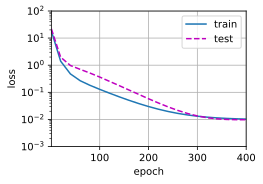

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.4597428 3.9528937]]


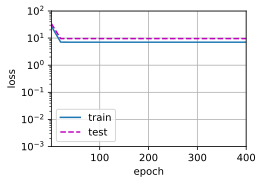

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9564543e+00  1.2192174e+00 -3.2015967e+00  5.4091620e+00
  -5.5862081e-01  9.4079292e-01  1.6903839e-01 -1.2290818e-01
   1.0401705e-02 -4.0972054e-02  8.2412558e-03 -5.3764634e-02
  -6.9650121e-02 -1.5937085e-01 -4.1621658e-03  9.0129197e-02
  -8.8063665e-02 -1.5993164e-01  1.6256860e-02  2.6524325e-03]]


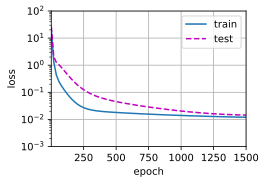

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)